In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

### Compare Overall survivals


[(-0.05, 1.05), Text(0.5, 1.0, 'Survival of patients with different source')]

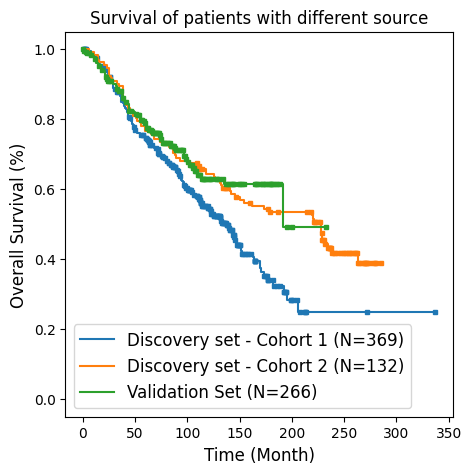

In [12]:
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))

survival_type = 'Overall'
length_column = "Overall Survival (Months)"
status_column = "Overall Survival Status"


clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})


# Cohort 1
length, event_observed = (
            clinical.loc[clinical.isDiscovery, length_column].dropna().values,
            clinical.loc[clinical.isDiscovery,status_column].dropna().values,
        )
label = "Discovery set - Cohort 1 (N={})".format(len(length))
kmf.fit(length, event_observed, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})

# Cohort 2
length, event_observed = (
            clinical.loc[~clinical.isDiscovery, length_column].dropna().values,
            clinical.loc[~clinical.isDiscovery,status_column].dropna().values,
        )
label = "Discovery set - Cohort 2 (N={})".format(len(length))
kmf.fit(length, event_observed, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})


clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
length_column = "Overall Survival (Months)"
status_column = "Overall Survival Status"
length, event_observed = (
            clinical[length_column].dropna().values,
            clinical[status_column].dropna().values,
        )
label = "Validation Set (N={})".format(len(length))
kmf.fit(length, event_observed, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, show_censors=True,censor_styles={"ms": 3, "marker": "s"})




ax.legend(ncol=1, fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel(survival_type +" Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05), title = 'Survival of patients with different source'
    )


# Danenberg

In [13]:

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)

clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})
clinical['Disease-specific Survival Status'] = clinical['Disease-specific Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
print("{} Patients with disease-specific survival data, {} patients with entire clinical data".format(len(clinical), len(clinical.dropna())))

for index, row in clinical.iterrows():
    er= row['ER Status']
    pr= row['PR Status']
    her2= row['HER2 Status']
    if (er == 'Positive' or pr == 'Positive') and her2 == 'Negative':
        clinical.loc[index, 'Clinical Subtype'] = 'HR+/HER2-'
    elif (er == 'Positive' or pr == 'Positive') and her2 == 'Positive':
        clinical.loc[index, 'Clinical Subtype'] = 'HR+/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Positive':
        clinical.loc[index, 'Clinical Subtype'] = 'HR-/HER2+'
    elif (er == 'Negative' and pr == 'Negative') and her2 == 'Negative':
        clinical.loc[index, 'Clinical Subtype'] = 'TNBC'

579 Patients with disease-specific survival data, 379 patients with entire clinical data


## Split by PAM50

### Cohort 1 v.s. Cohort 2

[(-0.05, 1.05), Text(0.5, 1.0, 'Cohort 2')]

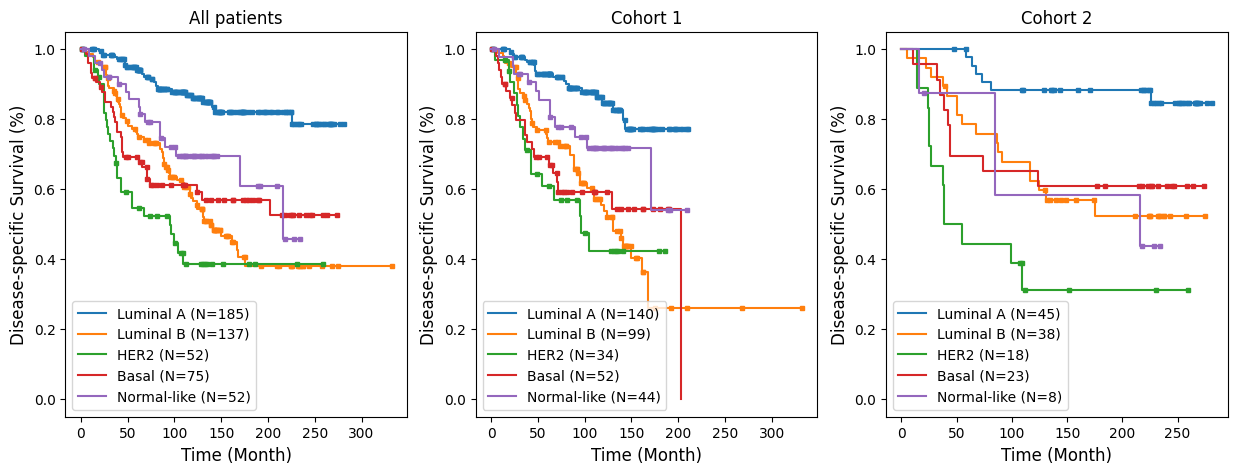

In [14]:
kmf = KaplanMeierFitter()
f, ax = plt.subplots(1, 3, figsize=(15, 5))

column_name = 'PAM50'
survival_type = 'Disease-specific'
length_column = "Disease-specific Survival (Months)"
status_column = "Disease-specific Survival Status"

feature_labels = ["Luminal A", "Luminal B", "HER2", "Basal", "Normal-like"]
for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            clinical[column_name]== feature, length_column
        ].values,
        clinical.loc[
            clinical[column_name] == feature, status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[0],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[0].legend(ncol=1, fontsize=10)
ax[0].set_xlabel("Time (Month)", fontsize=12)
ax[0].set_ylabel(survival_type+" Survival (%)", fontsize=12)
ax[0].set(ylim=(-0.05, 1.05), title="All patients")

for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            (clinical[column_name]== feature) & (clinical.isDiscovery),
            length_column
        ].values,
        clinical.loc[
            (clinical[column_name] == feature) & (clinical.isDiscovery),
            status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[1],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[1].legend(ncol=1, fontsize=10)
ax[1].set_xlabel("Time (Month)", fontsize=12)
ax[1].set_ylabel(survival_type+" Survival (%)", fontsize=12)
ax[1].set(ylim=(-0.05, 1.05), title="Cohort 1")

for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            (clinical[column_name] == feature) & (~clinical.isDiscovery),
            length_column
        ].values,
        clinical.loc[
            (clinical[column_name] == feature) & (~clinical.isDiscovery),
            status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[2],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[2].legend(ncol=1, fontsize=10)
ax[2].set_xlabel("Time (Month)", fontsize=12)
ax[2].set_ylabel(survival_type+" Survival (%)", fontsize=12)
ax[2].set(ylim=(-0.05, 1.05), title="Cohort 2")

### Subset 1 v.s. Subset 2 (Randomly split)

In [15]:
import random
random.seed(0)
Subset_id = [1] * (len(clinical) - 200) + [2] * 200
random.shuffle(Subset_id)
clinical['Subset_id'] = Subset_id

579


[(-0.05, 1.05), Text(0.5, 1.0, 'Subset 2')]

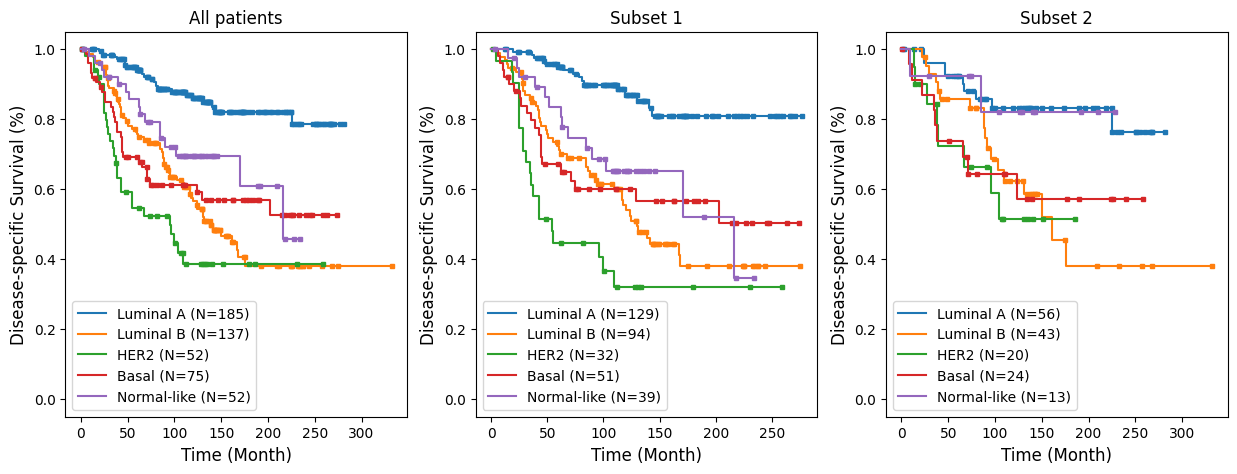

In [16]:
import random
random.seed(0)
Subset_id = [1] * 400 + [2] * (len(clinical) - 400)
print(len(Subset_id))
random.shuffle(Subset_id)
clinical['Subset_id'] = Subset_id

kmf = KaplanMeierFitter()
f, ax = plt.subplots(1, 3, figsize=(15, 5))



column_name = 'PAM50'
feature_labels = ["Luminal A", "Luminal B", "HER2", "Basal", "Normal-like"]
for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            clinical[column_name]== feature, length_column
        ].values,
        clinical.loc[
            clinical[column_name] == feature, status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[0],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[0].legend(ncol=1, fontsize=10)
ax[0].set_xlabel("Time (Month)", fontsize=12)
ax[0].set_ylabel(survival_type+" Survival (%)", fontsize=12)
ax[0].set(ylim=(-0.05, 1.05), title="All patients")

for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            (clinical[column_name]== feature) & (clinical.Subset_id == 1),
            length_column
        ].values,
        clinical.loc[
            (clinical[column_name] == feature) & (clinical.Subset_id == 1),
            status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[1],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[1].legend(ncol=1, fontsize=10)
ax[1].set_xlabel("Time (Month)", fontsize=12)
ax[1].set_ylabel(survival_type+" Survival (%)", fontsize=12)
ax[1].set(ylim=(-0.05, 1.05), title="Subset 1")

for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            (clinical[column_name] == feature) & (clinical.Subset_id == 2),
            length_column
        ].values,
        clinical.loc[
            (clinical[column_name] == feature) & (clinical.Subset_id == 2),
            status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[2],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[2].legend(ncol=1, fontsize=10)
ax[2].set_xlabel("Time (Month)", fontsize=12)
ax[2].set_ylabel(survival_type+" Survival (%)", fontsize=12)
ax[2].set(ylim=(-0.05, 1.05), title="Subset 2")

## Split by Clinical Subtype

### Cohort 1 v.s. Cohort 2

[(-0.05, 1.05), Text(0.5, 1.0, 'Cohort 2')]

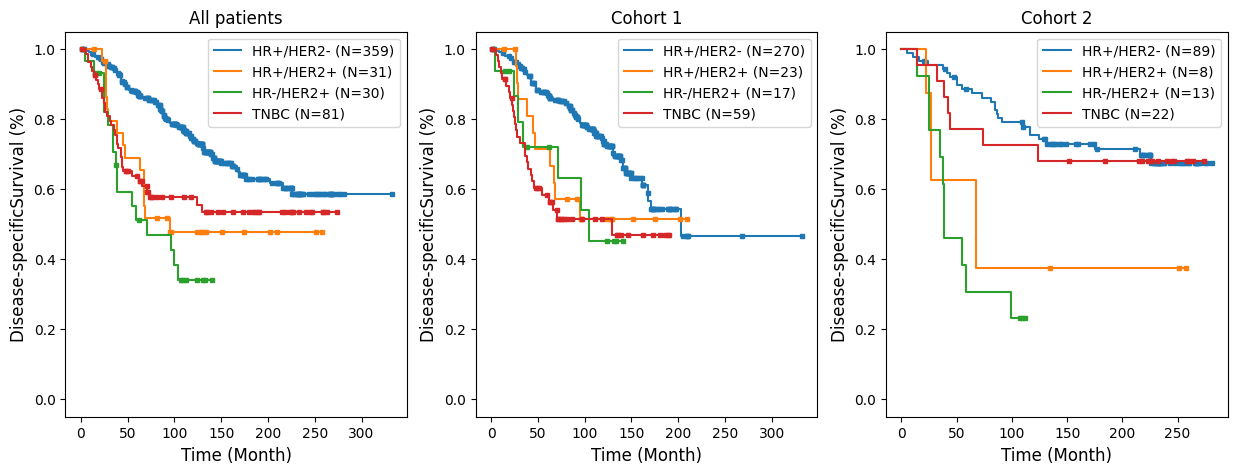

In [17]:
kmf = KaplanMeierFitter()
f, ax = plt.subplots(1, 3, figsize=(15, 5))

column_name = 'Clinical Subtype'
feature_labels = ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"]
for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            clinical[column_name]== feature, length_column
        ].values,
        clinical.loc[
            clinical[column_name] == feature, status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[0],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[0].legend(ncol=1, fontsize=10)
ax[0].set_xlabel("Time (Month)", fontsize=12)
ax[0].set_ylabel(survival_type+"Survival (%)", fontsize=12)
ax[0].set(ylim=(-0.05, 1.05), title="All patients")

for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            (clinical[column_name]== feature) & (clinical.isDiscovery),
            length_column,
        ].values,
        clinical.loc[
            (clinical[column_name] == feature) & (clinical.isDiscovery),
            status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[1],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[1].legend(ncol=1, fontsize=10)
ax[1].set_xlabel("Time (Month)", fontsize=12)
ax[1].set_ylabel(survival_type+"Survival (%)", fontsize=12)
ax[1].set(ylim=(-0.05, 1.05), title="Cohort 1")

for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            (clinical[column_name] == feature) & (~clinical.isDiscovery),
            length_column,
        ].values,
        clinical.loc[
            (clinical[column_name] == feature) & (~clinical.isDiscovery),
            status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[2],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[2].legend(ncol=1, fontsize=10)
ax[2].set_xlabel("Time (Month)", fontsize=12)
ax[2].set_ylabel(survival_type+"Survival (%)", fontsize=12)
ax[2].set(ylim=(-0.05, 1.05), title="Cohort 2")

### Subset 1 v.s. Subset 2 (Randomly split)

In [18]:
import random
random.seed(0)
Subset_id = [1] * (len(clinical) - 200) + [2] * 200
random.shuffle(Subset_id)
clinical['Subset_id'] = Subset_id

[(-0.05, 1.05), Text(0.5, 1.0, 'Subset 2')]

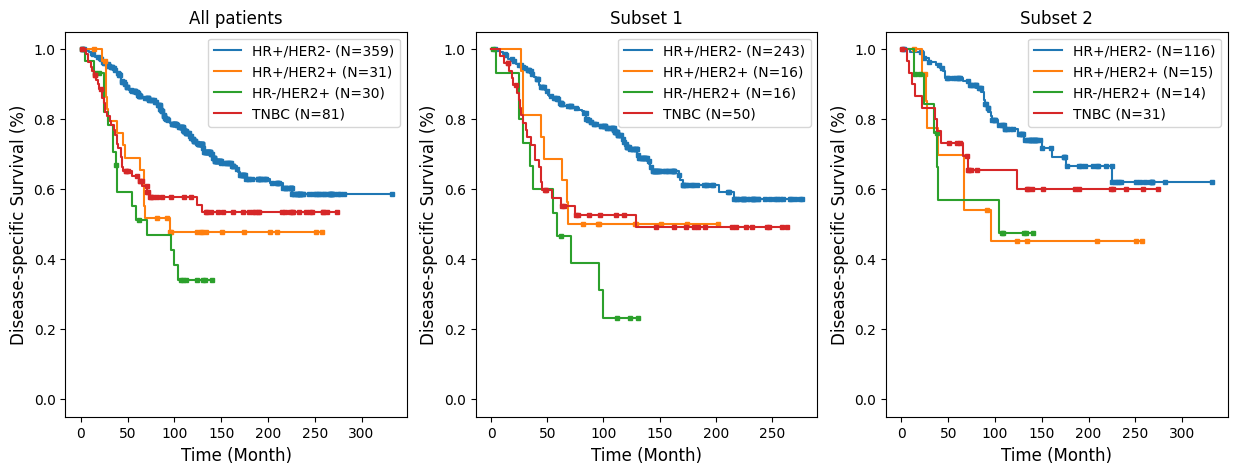

In [19]:
kmf = KaplanMeierFitter()
f, ax = plt.subplots(1, 3, figsize=(15, 5))

column_name = 'Clinical Subtype'
feature_labels = ["HR+/HER2-", "HR+/HER2+", "HR-/HER2+", "TNBC"]
for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            clinical[column_name]== feature, length_column
        ].values,
        clinical.loc[
            clinical[column_name] == feature, status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[0],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[0].legend(ncol=1, fontsize=10)
ax[0].set_xlabel("Time (Month)", fontsize=12)
ax[0].set_ylabel(survival_type+" Survival (%)", fontsize=12)
ax[0].set(ylim=(-0.05, 1.05), title="All patients")

for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            (clinical[column_name]== feature) & (clinical.Subset_id == 1),
            length_column
        ].values,
        clinical.loc[
            (clinical[column_name] == feature) & (clinical.Subset_id == 1),
            status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[1],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[1].legend(ncol=1, fontsize=10)
ax[1].set_xlabel("Time (Month)", fontsize=12)
ax[1].set_ylabel(survival_type+" Survival (%)", fontsize=12)
ax[1].set(ylim=(-0.05, 1.05), title="Subset 1")

for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            (clinical[column_name] == feature) & (clinical.Subset_id == 2),
            length_column
        ].values,
        clinical.loc[
            (clinical[column_name] == feature) & (clinical.Subset_id == 2),
            status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax[2],
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax[2].legend(ncol=1, fontsize=10)
ax[2].set_xlabel("Time (Month)", fontsize=12)
ax[2].set_ylabel(survival_type+" Survival (%)", fontsize=12)
ax[2].set(ylim=(-0.05, 1.05), title="Subset 2")

## Save randomly assigned subset id

In [20]:
clinical.to_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    ),
    index=False,
)

# Jackson

In [3]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)

clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})
print("{} Patients with disease-specific survival data, {} patients with entire clinical data".format(len(clinical), len(clinical.dropna())))

266 Patients with disease-specific survival data, 88 patients with entire clinical data


#### Split by Clincial Subtype

[(-0.05, 1.05), Text(0.5, 1.0, 'All patients')]

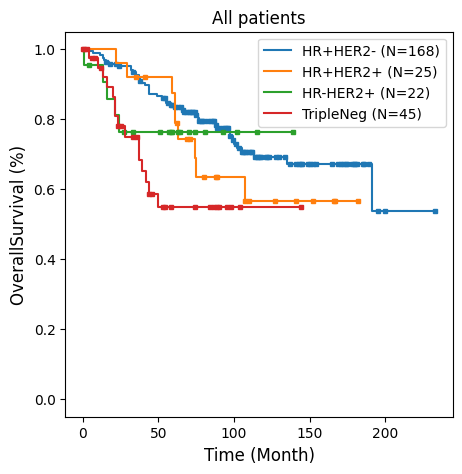

In [5]:
kmf = KaplanMeierFitter()
f, ax = plt.subplots(1, 1, figsize=(5, 5))

column_name = 'clinical_type'
survival_type = 'Overall'
length_column = "Overall Survival (Months)"
status_column = "Overall Survival Status"
feature_labels = ["HR+HER2-", "HR+HER2+", "HR-HER2+", "TripleNeg"]
for feature in feature_labels:
    length, event_observed = (
        clinical.loc[
            clinical[column_name]== feature, length_column
        ].values,
        clinical.loc[
            clinical[column_name] == feature, status_column
        ].values,
    )
    label = "{} (N={})".format(feature, len(length))
    kmf.fit(length, event_observed, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 3, "marker": "s"},
    )

ax.legend(ncol=1, fontsize=10)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel(survival_type+"Survival (%)", fontsize=12)
ax.set(ylim=(-0.05, 1.05), title="All patients")